In [9]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import csv
import warnings
import statsmodels.api as sm

In [10]:
warnings.filterwarnings("ignore")

In [11]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()
    
def plot_linear_regression(column, linear_a, linear_b, linear_a_half, linear_b_half):
    plt.figure(figsize=(10, 6))
    plt.scatter(column.index, column, label='Original Values')
    plt.plot(column.index, linear_a * column.index + linear_b, color='red', label='Linear Regression')
    plt.plot(column.index, linear_a_half * column.index + linear_b_half, color='green', label='Recent Linear Regression')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.title('Original Values vs. Linear Regression vs. Recent Linear Regression')
    plt.grid(True)
    plt.show()

In [12]:
def centered_moving_average(column, window_action, window_size):
    start_index, end_index = window_action
    data = column.to_numpy()

    data_length = len(data)

    for i in range(start_index, end_index + 1):
        if not np.isnan(data[i]):
            init = data[i]
            start = max(0, i - window_size)
            end = min(data_length, i + window_size + 1)
            window = data[start:end]
            valid_values = [value for value in window if not pd.isna(value)]
            if len(valid_values) > 0:
                data[i] = np.mean(valid_values)

    modified_column = pd.Series(data, name=column.name)

    return modified_column

In [13]:
# Polynomial Interpolation data inputation method
def four_ends_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        for i in range(4):
            column = first_filler(column, i, len(column) - 1 - i)
            column = last_filler(column, i, len(column) - 1 - i)
    return column

def four_ends_linear_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        size = len(column) - 1
        column = first_filler(column, 0, size)
        column = last_filler(column, 0, size)
        for i in range(1, 4):
            value = column.at[i]
            if (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_first = i - 1
                end_first = next_valid_index(column, i)
                linear_a = (column.at[end_first] - column.at[i - 1])/(end_first - start_first)
                linear_b = column.at[start_first] - linear_a*start_first
                column.at[i] = linear_a*i + linear_b
            x = size - 4 + i
            value = column.at[x]
            if (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_last = prev_valid_index(column, x)
                end_last = next_valid_index(column, x)
                gap = list(range(start_last + 1, end_last))
                linear_a = (column.at[end_last] - column.at[start_last])/(end_last - start_last)
                linear_b = column.at[start_last] - linear_a*start_last
                column.at[x] = linear_a*x + linear_b
    return column

def first_filler(column, init, end):
    if pd.isnull(column.at[init]) or np.isnan(column.at[init]):
        first_valid_index = 0
        while first_valid_index <= end and (pd.isnull(column.at[first_valid_index]) or 
                                             np.isnan(column.at[first_valid_index])):
            first_valid_index += 1
        if first_valid_index > end:
            column.at[init] = 0.0
        else:
            column.at[init] = column.at[first_valid_index]
    return column

def extract_valid_values(column):
    valid_values = []
    valid_indexes = []
    for index, value in enumerate(column):
        if not pd.isnull(value) and not np.isnan(value):
            valid_values.append(value)
            valid_indexes.append(index)
    extracted_column = pd.Series(
        valid_values,
        index=valid_indexes
    )
    return extracted_column

def linear_regression_first_four_filler(column):
    size = len(column) - 1
    processed_column = extract_valid_values(column)
    mean_valid_values_quarter = processed_column.mean()/4
    mean_valid_values_quarter_upper = processed_column.mean() + mean_valid_values_quarter
    
    model = sm.OLS(processed_column, sm.add_constant(processed_column.index))
    result = model.fit()
    linear_a = result.params[1]
    linear_b = result.params['const']
    half_column = processed_column[:(len(processed_column) // 2)]
    model2 = sm.OLS(half_column, sm.add_constant(half_column.index))
    result2 = model2.fit()
    linear_a_half = result2.params[1]
    linear_b_half = result2.params['const']
    
    for i in range(0,4):
        if pd.isnull(column.at[i]) or np.isnan(column.at[i]):
            projected = ((linear_a*i + linear_b) + (linear_a_half*i + linear_b_half))/2
            if projected < mean_valid_values_quarter:
                column.at[i] = mean_valid_values_quarter
            elif projected > mean_valid_values_quarter_upper:
                column.at[i] = mean_valid_values_quarter_upper
            else:
                column.at[i] = projected
        x = size - 4 + i
        if pd.isnull(column.at[x]) or np.isnan(column.at[x]):
            projected = ((linear_a*i + linear_b) + (linear_a_half*i + linear_b_half))/2
            if projected < mean_valid_values_quarter:
                column.at[x] = mean_valid_values_quarter
            elif projected > mean_valid_values_quarter_upper:
                column.at[x] = mean_valid_values_quarter_upper
            else:
                column.at[x] = projected
    plot_linear_regression(column, linear_a, linear_b, linear_a_half, linear_b_half)
    return column
    
def last_filler(column, init, end):
    if pd.isnull(column.at[end]) or np.isnan(column.at[end]):
        last_valid_index = len(column) -1
        while last_valid_index >= init and (pd.isnull(column.at[last_valid_index]) or 
                                         np.isnan(column.at[last_valid_index])):
            last_valid_index -= 1
        if last_valid_index < init:
            column.at[end] = 0.0
        else:
            column.at[end] = column.at[last_valid_index]
    return column
  
def neareast_four_indexes(column, start, end):
    return prev_four_valid_indexes(column, start) + next_four_valid_indexes(column, end)

def prev_four_valid_indexes(column, pos):
    prev_index = pos
    index_prev_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_prev_list[3 - i] = prev_index
            prev_index -= 1
            while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
                prev_index -= 1
    return index_prev_list  

def next_four_valid_indexes(column, pos):
    next_index = pos
    index_next_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_next_list[i] = next_index
            next_index += 1
            while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
                next_index += 1
    return index_next_list  

def prev_valid_index(column, pos):
    prev_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        prev_index -= 1
        while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
            prev_index -= 1
    return prev_index  

def next_valid_index(column, pos):
    next_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        next_index += 1
        while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
            next_index += 1
    return next_index

def interpolating_polynomial(nearest_indexes, nearest_values):
    coeffs = np.polyfit(nearest_indexes, nearest_values, 3)
    return np.poly1d(coeffs)

def polynomial_filler(column):
    size = len(column) -1
    if column.isnull().any() and column.isna().any():
        for i, value in enumerate(column):
            if (i > 3 and i < size - 3) and (pd.isnull(value) or np.isnan(value) or (value == '')):
                nearest_values = []
                start = prev_valid_index(column, i)
                end = next_valid_index(column, i)
                gap = list(range(start + 1, end))
                nearest_indexes = neareast_four_indexes(column, start, end)
                for index in nearest_indexes:
                    nearest_values.append(column.at[index])
                polynomial = interpolating_polynomial(nearest_indexes, nearest_values)
                for x in gap:
                    column.at[x] = polynomial(x)
                plot_polynomial(polynomial, nearest_indexes[0], nearest_indexes[len(nearest_indexes) - 1], 50, gap, nearest_indexes, column.name)
    return column

def plot_polynomial(polynomial, start, end, precision, interpolated_list, nearest_indexes, column_name):
    x = np.linspace(start, end, precision)
    y = polynomial(x)

    plt.figure()

    plt.plot(x, y)

    interpolated_x = interpolated_list  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='red')
    interpolated_x = nearest_indexes  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='green')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(column_name)

    plt.show()
    
def replace_negative_with_float_zeros(x):
    return 0.0 if x < 0 else x

In [14]:
def insert_empty_rows(df, init, end):
    blank_years = list(range(init, end))
    empty_rows = [pd.DataFrame({'Year': [year] + [''] * (df.shape[1] - 1)}) for year in blank_years]
    df = pd.concat([pd.DataFrame({'Year': [year]}) for year in years_to_insert] + [df], ignore_index=True)
    df = df.sort_values(by='Year').reset_index(drop=True)

    return df

In [15]:
def read_csv_replace_missing_by_polynomial(file_path, skiped_rows, skiped_columns):
    with open(file_path, 'r') as f:
        
        df = pd.read_csv(file_path, skiprows=skiped_rows)
        
        i = 0
        for col in df.columns: # Elimina missing values por médias e transforma em float
            if i > skiped_columns:
                df[col] = df[col].replace('-9999', np.nan)
                df[col] = df[col].replace('-', np.nan)
                df[col] = df[col].replace('', np.nan).astype(float)
                df[col] = linear_regression_first_four_filler(df[col])
                df[col] = centered_moving_average(df[col], (0, len(df[col]) - 1), 3) #3 meses
                df[col] = polynomial_filler(df[col])
                df[col] = df[col].apply(replace_negative_with_float_zeros)
            i += 1
        return df

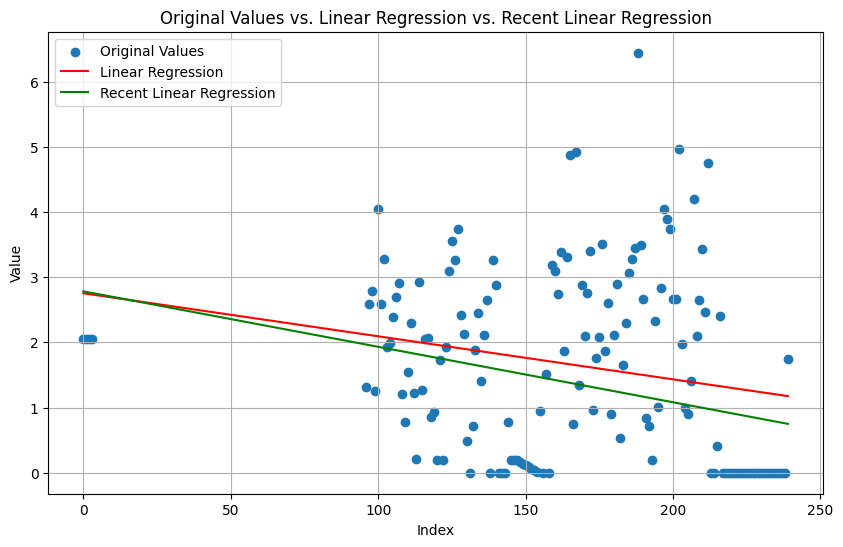

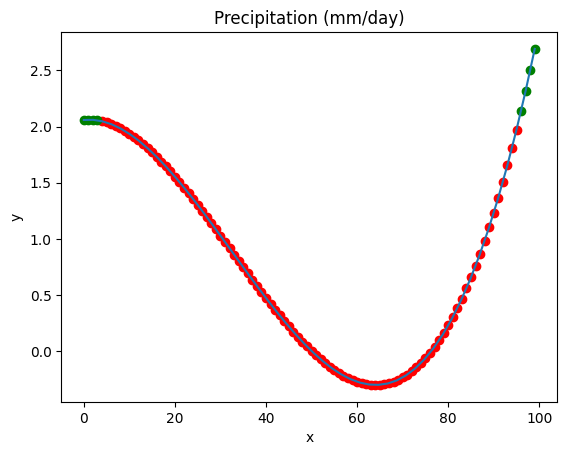

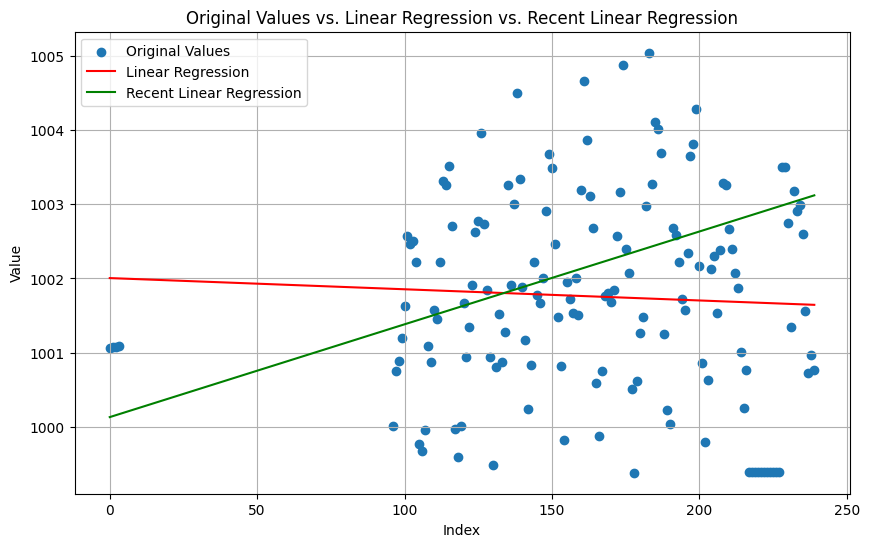

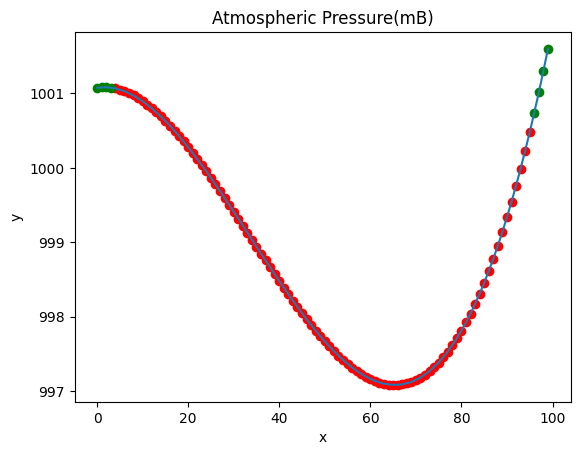

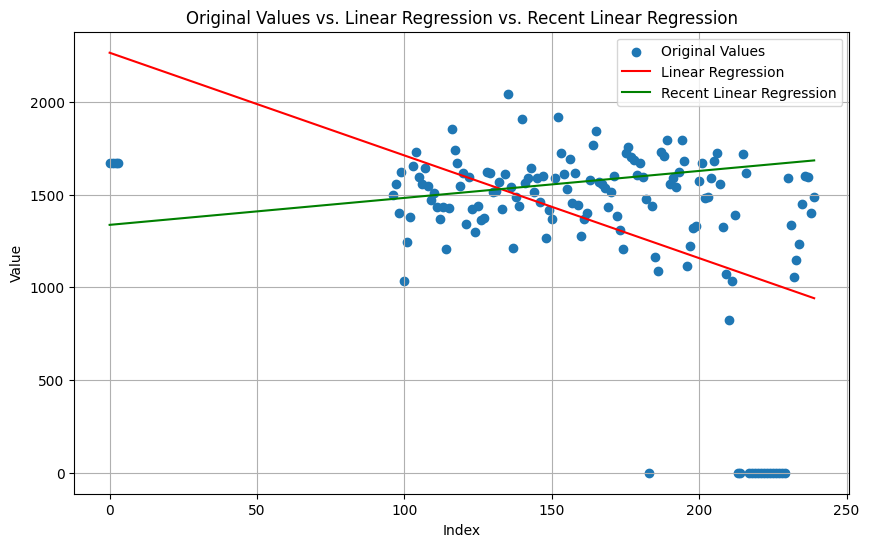

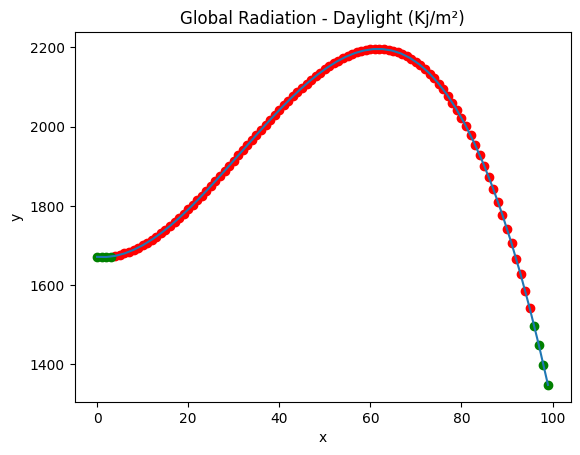

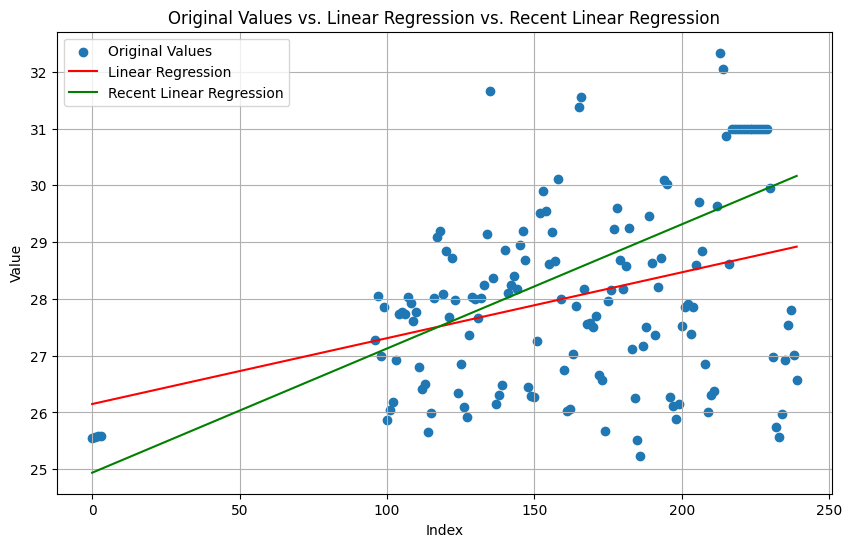

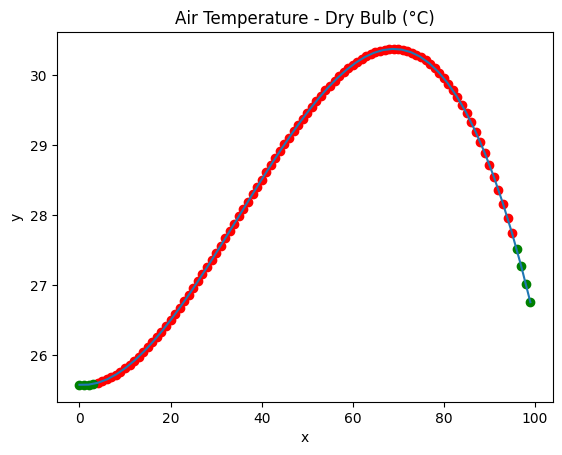

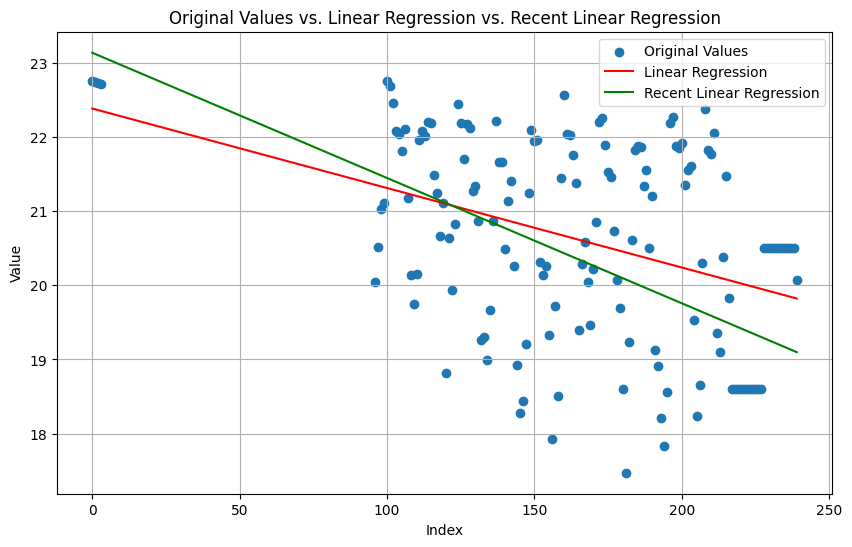

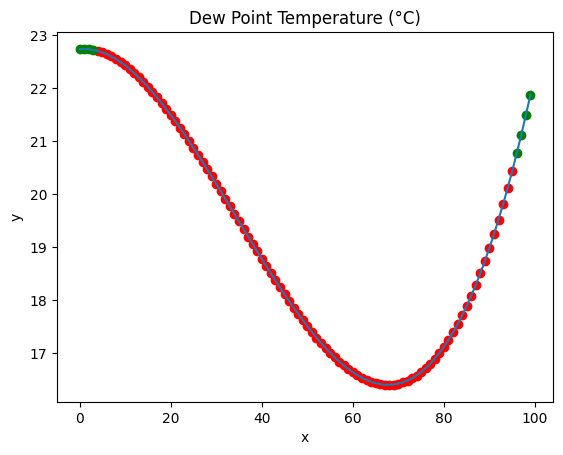

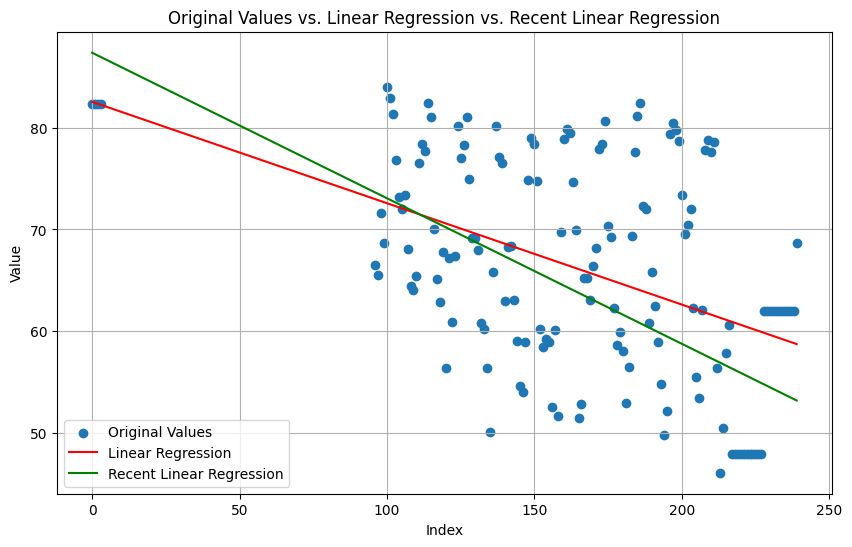

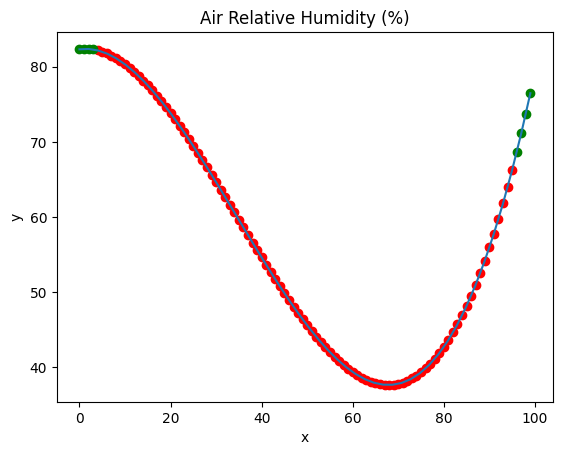

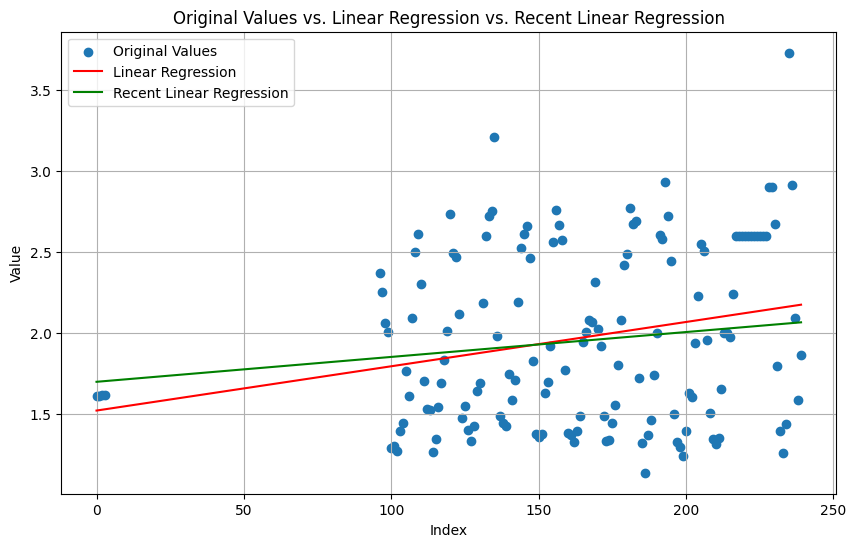

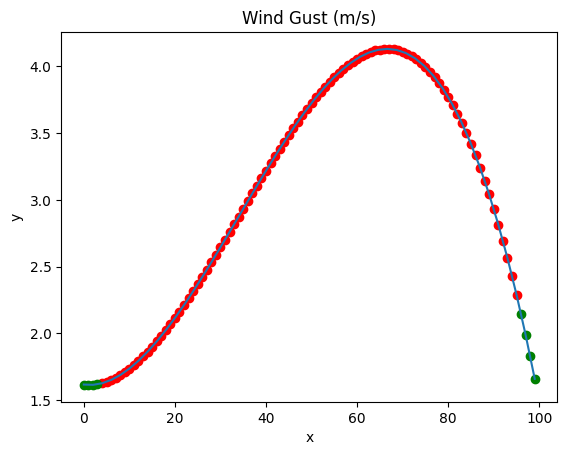

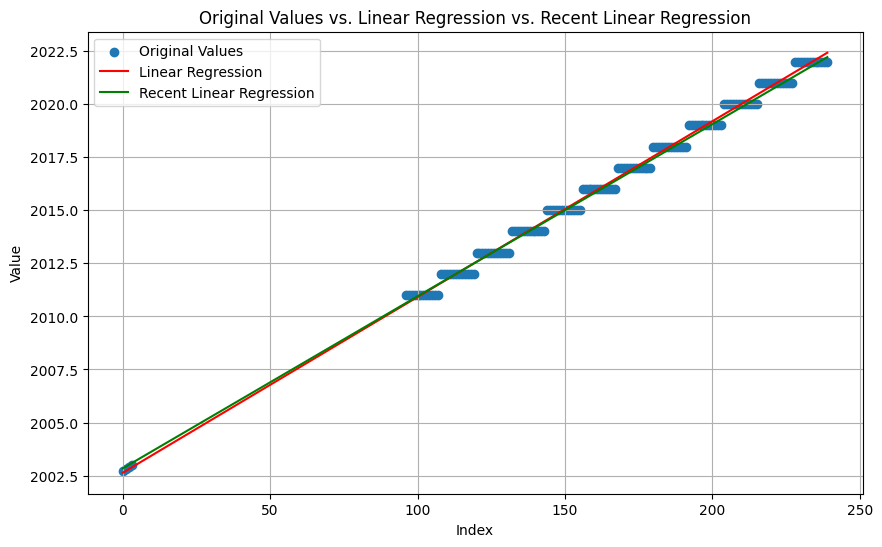

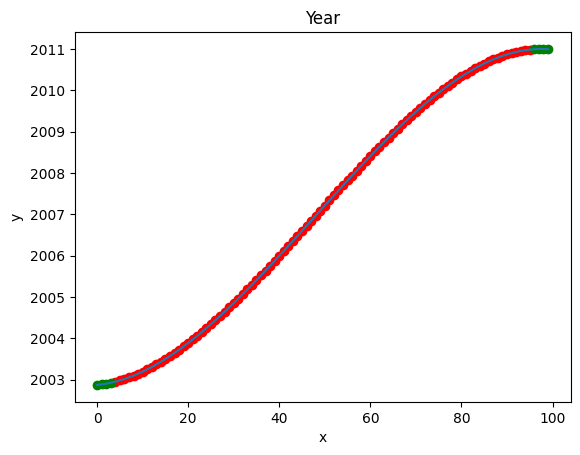

,Ano,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Year
0,2003,2.058778,1001.077198,1671.347636,25.569094,22.736364,82.325261,1.614960,2002.863815
1,2003,2.058778,1001.079258,1671.347636,25.575369,22.731191,82.325261,1.615759,2002.894526
2,2003,2.058778,1001.080459,1671.347636,25.579030,22.728173,82.325261,1.616226,2002.912441
3,2003,2.058778,1001.080588,1671.347636,25.579422,22.727849,82.325261,1.616276,2002.914360
4,2003,2.047445,1001.066958,1673.953674,25.600512,22.700959,82.163288,1.626211,2002.950354
...,...,...,...,...,...,...,...,...,...
235,2022,0.000383,1001.876045,1372.952659,27.207036,20.463386,61.729585,2.409839,2021.980331
236,2022,0.249519,1001.506562,1422.382102,27.178478,20.413409,62.770426,2.197567,2021.986821
237,2022,0.332550,1001.337412,1429.642235,27.148597,20.398080,63.127190,2.079315,2021.989698
238,2022,0.465456,1001.289107,1422.380936,27.024825,20.368093,63.657698,2.027643,2021.991370


In [16]:
df = read_csv_replace_missing_by_polynomial('roraima_variacao_climatica.csv', 0, 1)
df.rename(columns={'Date': 'Ano'}, inplace=True)
df['Ano'] = df['Ano'].str[:4].astype(int)
df.drop(columns='State', inplace=True)
df

In [17]:
import re

df_indexed = df.set_index('Ano')

def correct_index(df):
    new_index = []
    for i, index_value in enumerate(df.index):
        new_index.append(f"{index_value}-{i % 12 + 1}")
    df.index = new_index
    return df

df_indexed = correct_index(df_indexed)
df_indexed = df_indexed.drop('Year', axis=1)
df_indexed

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s)
2003-1,2.058778,1001.077198,1671.347636,25.569094,22.736364,82.325261,1.614960
2003-2,2.058778,1001.079258,1671.347636,25.575369,22.731191,82.325261,1.615759
2003-3,2.058778,1001.080459,1671.347636,25.579030,22.728173,82.325261,1.616226
2003-4,2.058778,1001.080588,1671.347636,25.579422,22.727849,82.325261,1.616276
2003-5,2.047445,1001.066958,1673.953674,25.600512,22.700959,82.163288,1.626211
...,...,...,...,...,...,...,...
2022-8,0.000383,1001.876045,1372.952659,27.207036,20.463386,61.729585,2.409839
2022-9,0.249519,1001.506562,1422.382102,27.178478,20.413409,62.770426,2.197567
2022-10,0.332550,1001.337412,1429.642235,27.148597,20.398080,63.127190,2.079315
2022-11,0.465456,1001.289107,1422.380936,27.024825,20.368093,63.657698,2.027643


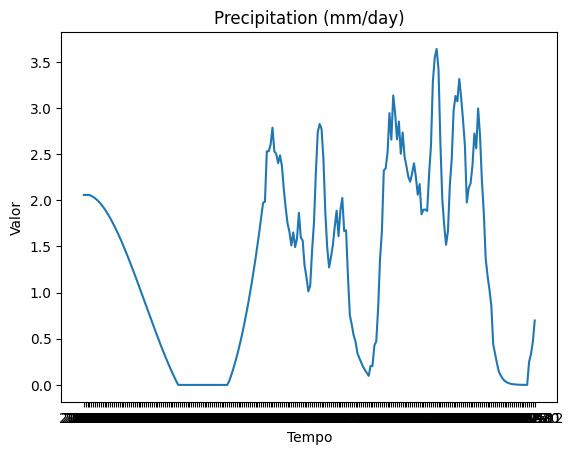

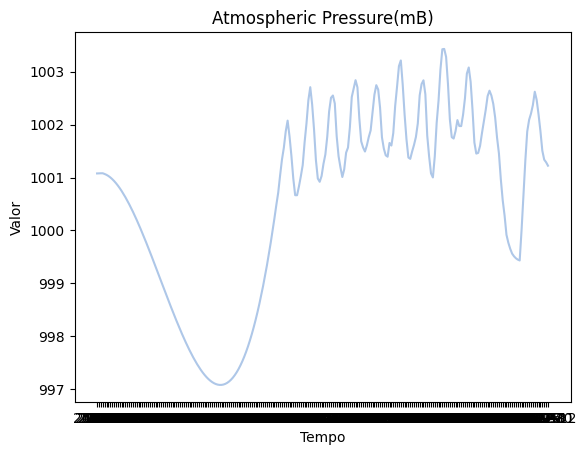

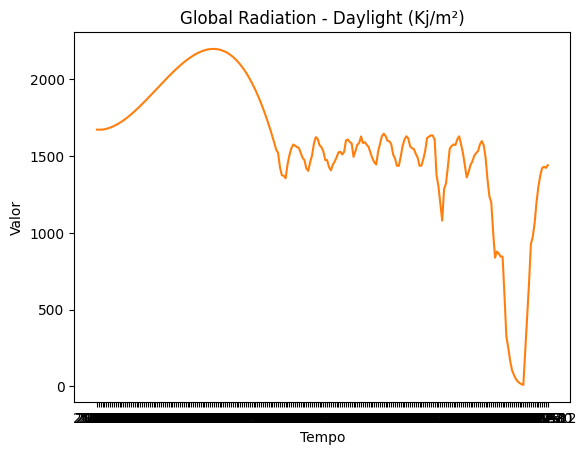

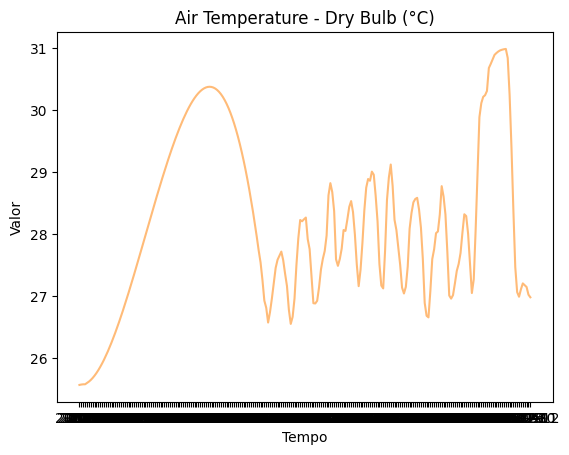

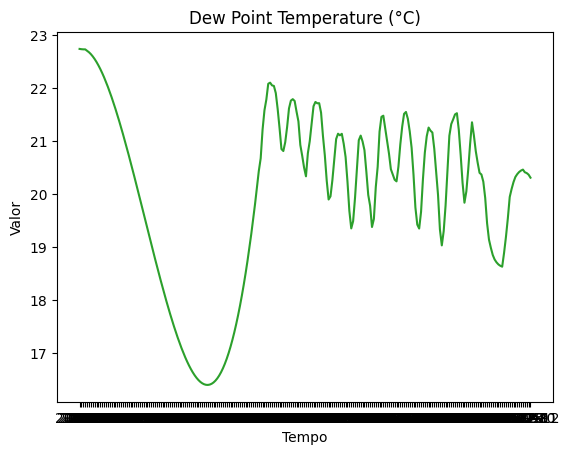

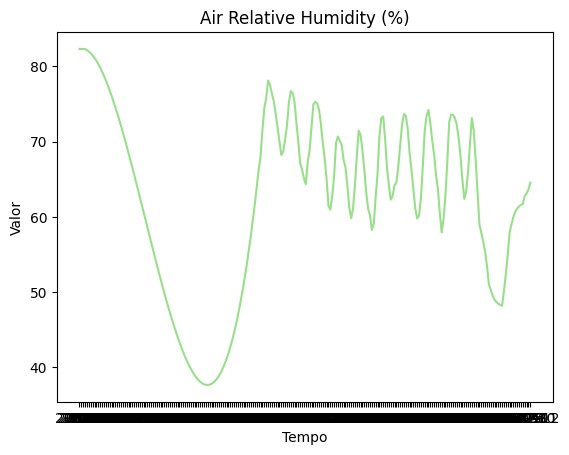

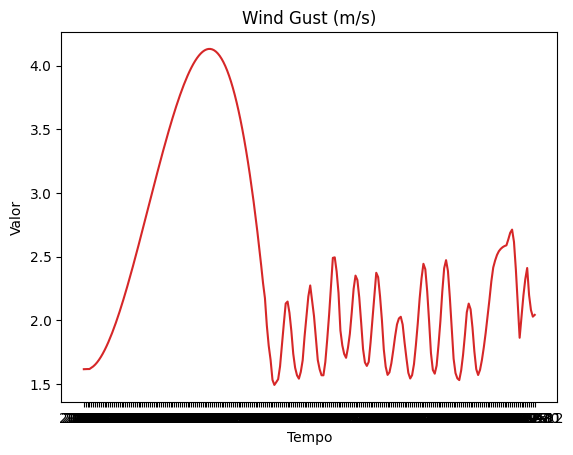

In [18]:
plot_columns(df_indexed)

In [19]:
df_indexed.to_csv('2003_mo_meteo.csv')

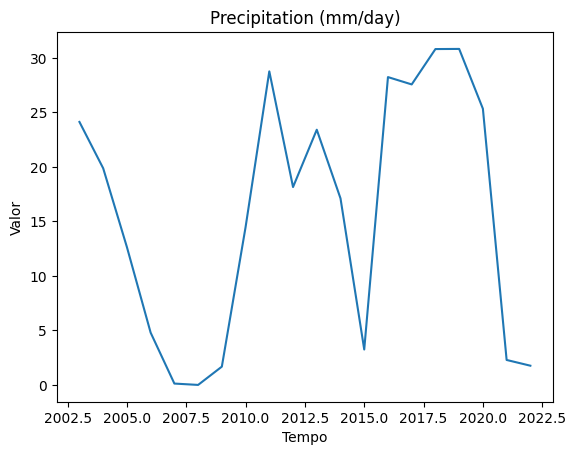

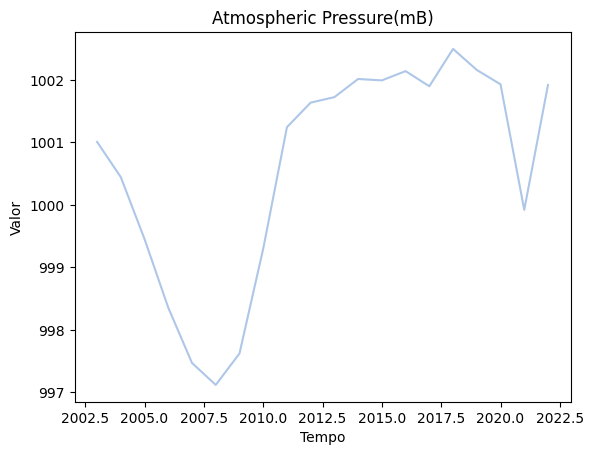

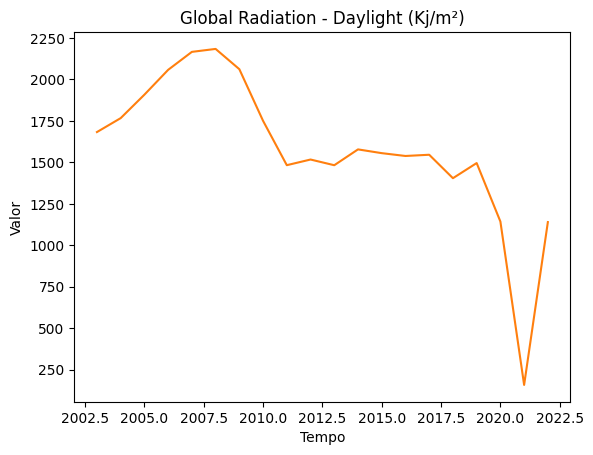

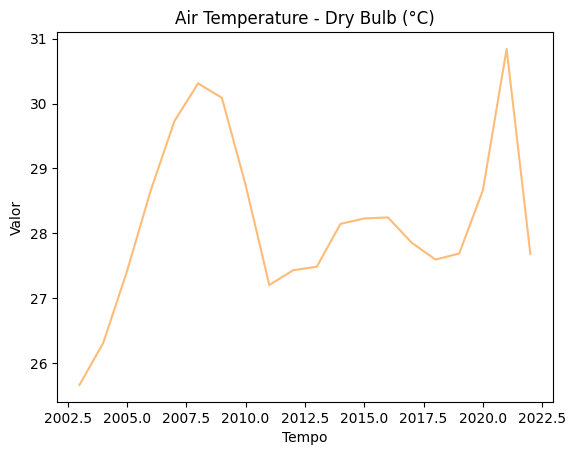

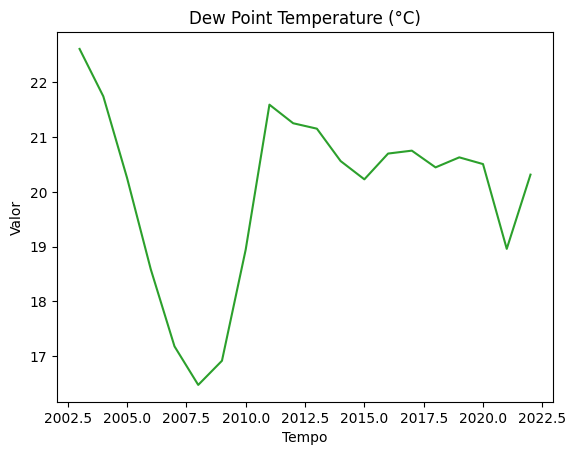

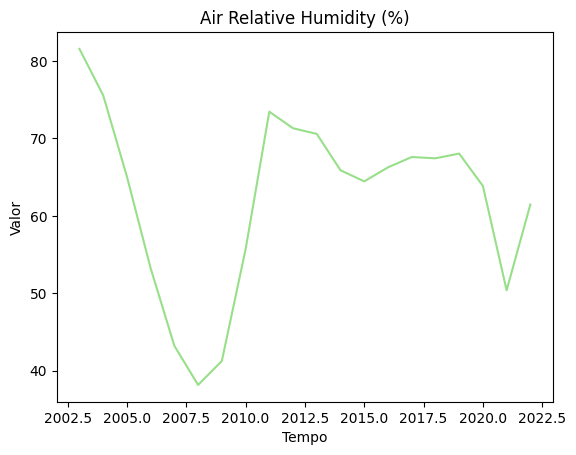

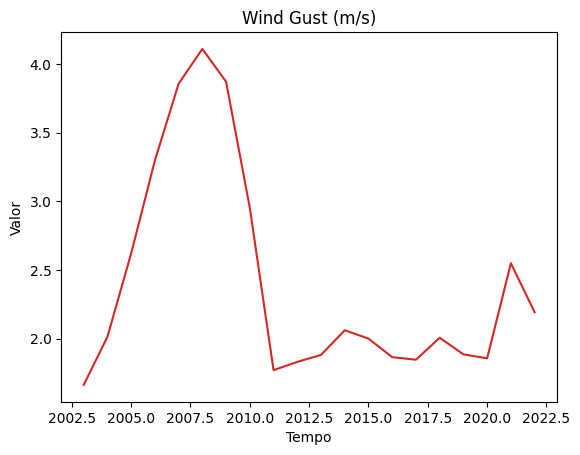

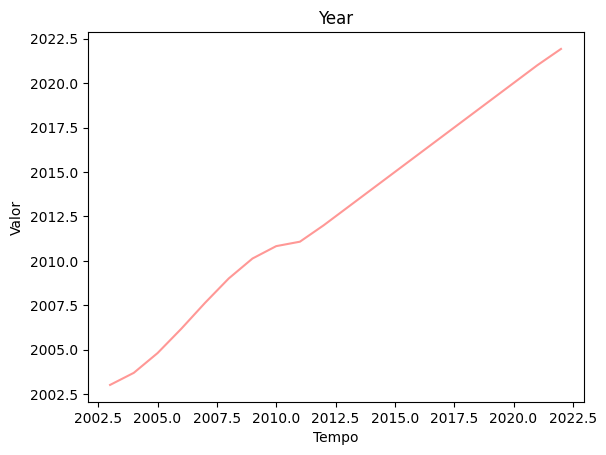

In [20]:
df_year = df.copy()
df_year.set_index('Ano', inplace=True)
df_year = df_year.groupby('Ano').mean()
df_year['Precipitation (mm/day)'] = df_year['Precipitation (mm/day)'] * 12
plot_columns(df_year)

In [21]:
df_2003 = df_year[df_year.index >= 2003]
df_2003

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Year
Ano,,,,,,,,
2003,24.132117,1001.009776,1682.636213,25.666744,22.612208,81.556183,1.661984,2003.022368
2004,19.880981,1000.445068,1766.712684,26.310802,21.746401,75.572466,2.012502,2003.702324
2005,12.647715,999.453231,1908.272854,27.412484,20.257744,65.079111,2.619738,2004.811648
2006,4.795861,998.354558,2057.944732,28.656431,18.588395,53.238901,3.296376,2006.179757
2007,0.124682,997.469347,2166.353730,29.727284,17.180520,43.214685,3.855096,2007.636068
2008,0.000000,997.117897,2184.125262,30.309679,16.476287,38.169313,4.108579,2009.009997
2009,1.677249,997.620505,2061.884741,30.088254,16.917865,41.265633,3.869506,2010.130962
2010,14.476654,999.297470,1750.257580,28.747648,18.947421,55.666495,2.950558,2010.828378
2011,28.773098,1001.244576,1482.870163,27.204758,21.594412,73.451019,1.769560,2011.078474


In [22]:
df_2003.to_csv('2003_01_meteo.csv', index=True)

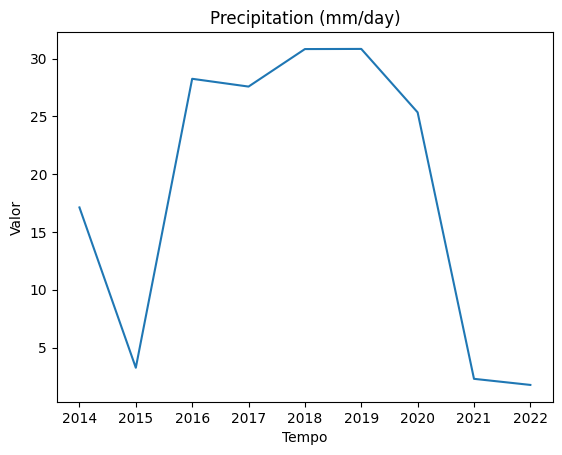

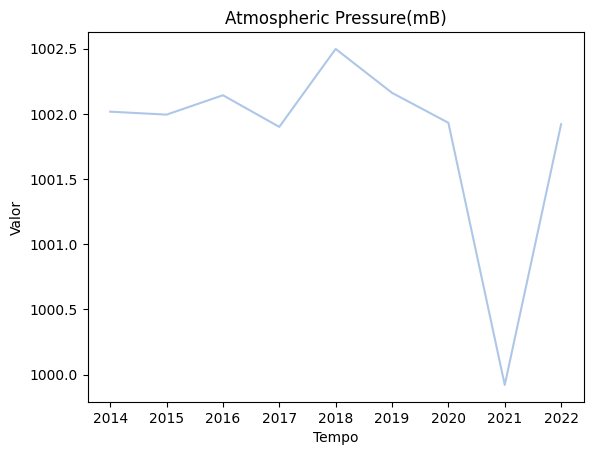

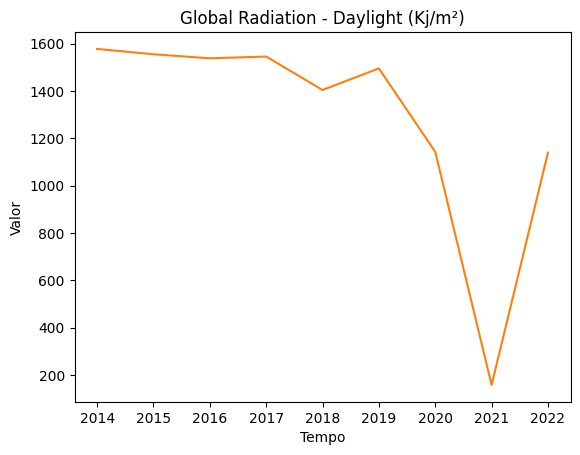

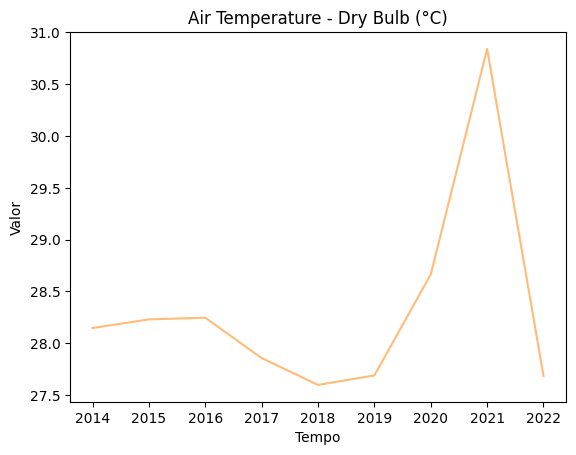

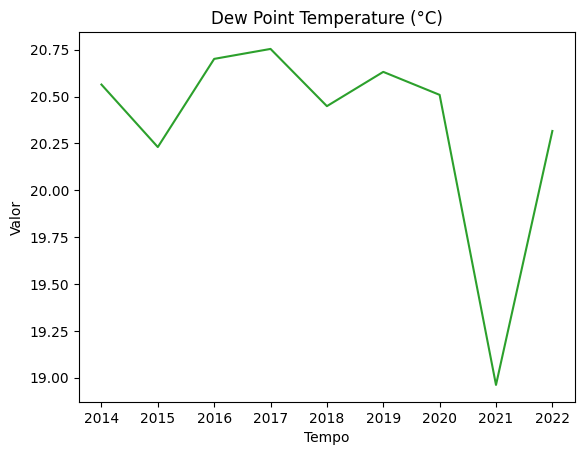

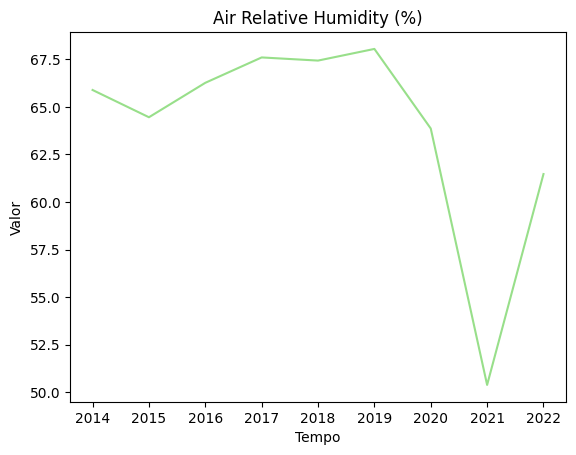

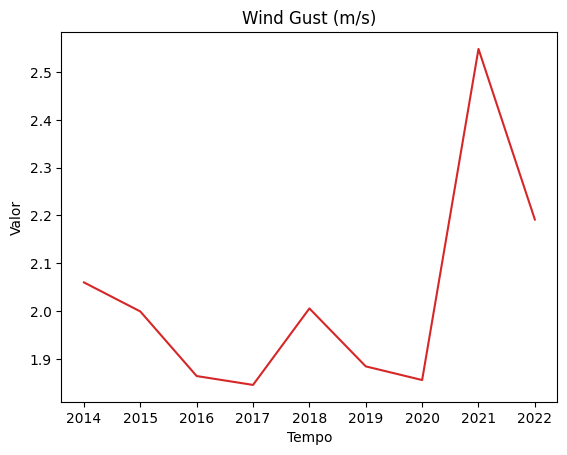

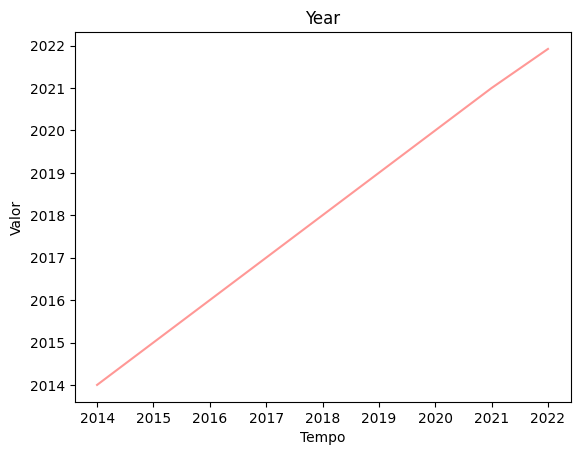

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Year
Ano,,,,,,,,
2014,17.118140,1002.016724,1578.079185,28.146738,20.564288,65.885430,2.059983,2014.000000
2015,3.250497,1001.994058,1555.444848,28.229679,20.230673,64.452989,1.999231,2015.000000
2016,28.247416,1002.142811,1538.391940,28.245826,20.701308,66.262581,1.864162,2016.000000
2017,27.574055,1001.900087,1545.794467,27.856320,20.754481,67.596483,1.845617,2017.000000
2018,30.818797,1002.497993,1404.391513,27.597358,20.449053,67.430923,2.005544,2018.000000
2019,30.831773,1002.161185,1495.711803,27.688825,20.631987,68.043831,1.884391,2019.000000
2020,25.342684,1001.931403,1142.901161,28.664319,20.509270,63.860611,1.855823,2020.000000
2021,2.290727,999.921016,157.442400,30.840560,18.961158,50.385030,2.548194,2021.000000
2022,1.763722,1001.920792,1139.610268,27.684228,20.316511,61.467241,2.191494,2021.920844


In [23]:
df_2014 = df_year[df_year.index >= 2014]
plot_columns(df_2014)
df_2014

In [24]:
df_2014.to_csv('2014_01_meteo.csv', index=True)

In [25]:
df_2008 = df_year[df_year.index >= 2008]
df_2008

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Year
Ano,,,,,,,,
2008,0.000000,997.117897,2184.125262,30.309679,16.476287,38.169313,4.108579,2009.009997
2009,1.677249,997.620505,2061.884741,30.088254,16.917865,41.265633,3.869506,2010.130962
2010,14.476654,999.297470,1750.257580,28.747648,18.947421,55.666495,2.950558,2010.828378
2011,28.773098,1001.244576,1482.870163,27.204758,21.594412,73.451019,1.769560,2011.078474
2012,18.157080,1001.638113,1516.989202,27.432195,21.254903,71.311728,1.829792,2012.000676
2013,23.417457,1001.725874,1482.624966,27.486970,21.155820,70.583909,1.880642,2013.000006
2014,17.118140,1002.016724,1578.079185,28.146738,20.564288,65.885430,2.059983,2014.000000
2015,3.250497,1001.994058,1555.444848,28.229679,20.230673,64.452989,1.999231,2015.000000
2016,28.247416,1002.142811,1538.391940,28.245826,20.701308,66.262581,1.864162,2016.000000


In [26]:
df_2008.to_csv('2008_01_meteo.csv', index=True)